<a href="https://colab.research.google.com/github/LondheShubham153/natural_language_processing/blob/main/email_spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages and Imports

Supressed Warnings

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns

## Reading Data

In [ ]:
data = pd.read_csv('SMSSpamCollection', sep="\t", names=['label','message'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


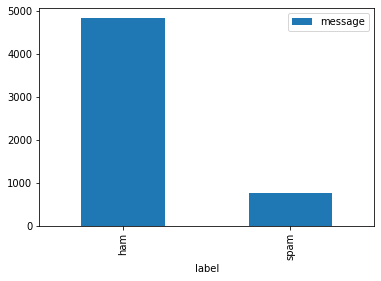

In [ ]:
data.groupby('label').count().plot.bar()

## Pre-processing Data

In [ ]:
class PreProcessor:

  def remove_punctuation(self, record):

    cleaned_str = [char for char in record if char not in string.punctuation]
    return ''.join(cleaned_str)
  
  def normalize_sentences(self, sentences):
    words = sentences.split(" ")
    return [word.lower() for word in words]

  def remove_stopwords(self,words):
    return [word for word in words if word not in stopwords.words("english")]

  def process(self, record):
      # Remove Punctuation
      sentences = self.remove_punctuation(record)
      
      # Normalize
      norm_words = self.normalize_sentences(sentences)
      
      # Remove Stopwords
      final_words = self.remove_stopwords(norm_words)
      
      return final_words

In [ ]:
processor = PreProcessor()
processor.process("Hey! Welcome to Train With Shubham channel! You will be learning a lot of cool stuff.")

['hey',
 'welcome',
 'train',
 'shubham',
 'channel',
 'learning',
 'lot',
 'cool',
 'stuff']

## Extract features and labels


In [ ]:
# Extract features and labels

features = data.iloc[:,[1]].values
label = data.iloc[:,0].values

## Creating Bag of Words

In [ ]:
#Initialize Count Vectorizer with our custom preprocessing function
word_vector = CountVectorizer(analyzer=processor.process)
#Build Vocab
final_word_vocab = word_vector.fit(features)

In [ ]:
bag_of_words = final_word_vocab.transform(features)
bag_of_words

<5572x13431 sparse matrix of type '<class 'numpy.int64'>'
	with 53461 stored elements in Compressed Sparse Row format>

## Applying TFIDF on BOW

In [ ]:
#Calculating TF and IDF

tfIdf_obj = TfidfTransformer().fit(bag_of_words)

#Transform data (Calc Weights )
final_feature = tfIdf_obj.transform(bag_of_words)

## Test-Train Split and Model building

In [ ]:
class ModelBuilder:
  def __init__(self):
    self.names = [
    "Nearest Neighbors",
    "Linear SVM",
    "Decision Tree",
    "Logistic_Regression"]

    self.classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    LogisticRegression()]


  def split_test_train(self, features,labels,size,state):
    X_train,X_test,y_train,y_test = train_test_split(features,
                                                label,
                                                test_size=size,
                                                random_state=state)
    return (X_train,X_test,y_train,y_test)

  def choose_best_model(self,X_test,X_train,y_test,y_train):
    scores = []
    best_model = self.classifiers[0]
    best_score = 0
    for name, clf in zip(self.names,self.classifiers):
      clf.fit(X_train,y_train)
      score = clf.score(X_test,y_test)
      scores.append(score)
      if score > best_score:
        best_model = clf
        best_score = score
    model_scores_df = pd.DataFrame()
    model_scores_df['Algorithm'] = self.names
    model_scores_df['Score'] = scores

    cm = sns.light_palette('orange',as_cmap=True)
    model_scores = model_scores_df.style.background_gradient(cmap=cm)
    print(f"The model that will perform well with {best_model}")
    return model_scores, best_model
  

In [ ]:
models = ModelBuilder()
X_test,X_train,y_test,y_train = models.split_test_train(final_feature,label,0.2,6)
scores,model = models.choose_best_model(X_test,X_train,y_test,y_train)
model.fit(X_train,y_train)
scores

The model that will perform well with KNeighborsClassifier(n_neighbors=3)


,Algorithm,Score
0,Nearest Neighbors,0.943235
1,Linear SVM,0.862688
2,Decision Tree,0.929100
3,Logistic_Regression,0.871663


## Spam Checker

In [ ]:
class SpamChecker:

  def predict(self,model,sms_input):
    """
    Pre Processing
    BOW transformation
    TFIDF transformation

    """
    pre_processed_features = processor.process(sms_input)
    bow_feature = final_word_vocab.transform(pre_processed_features)
    tfIdf_feature = tfIdf_obj.transform(bow_feature)
    return max(set(model.predict(tfIdf_feature)), key = list(model.predict(tfIdf_feature)).count)
    

In [ ]:
checker = SpamChecker()
checker.predict(model,"congratulations !! you have won a lottery, in order to get the prize amount click this link and be a millionare")

'spam'

In [ ]:
checker.predict(model,"Hey, how are you")

'ham'

## Conclusion

Dataset:

The dateset having 5572 records had an imbalance of "spam" and "ham" labels, with majority SMS records for "ham".




TF-IDF:

“Term Frequency — Inverse Document Frequency”. 

This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus. 

We used this method for Text Mining in the SMS dataset and it helped in quantifying the different words from the bag of words.

Output:

The output of the predict function gave good accuracy with random SMS messages, it didn't perform well when we gave small length spam messages.
Adding more training data shoulp help.